In [6]:
###################### Import à ne pas modifier ###################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##################################################################################

npzfile = np.load("dataExamen.npz",allow_pickle=True)
print(npzfile.files)

prices = npzfile["mPrice"]
dates = npzfile["vDates"]
names = npzfile["aNames"]

['mPrice', 'vDates', 'aNames']


In [2]:
# Conversion des prix en DataFrame pour une manipulation plus facile
df_prices = pd.DataFrame(prices, columns=names, index=pd.to_datetime(dates))
print(df_prices.head())

           (ACA FP, ACA FP Equity, CREDIT AGRICOLE SA)  \
2010-01-01                                       12.36   
2010-01-04                                      12.825   
2010-01-05                                       13.02   
2010-01-06                                       13.25   
2010-01-07                                      13.255   

           (AI FP, AI FP Equity, AIR LIQUIDE SA)  \
2010-01-01                               47.0768   
2010-01-04                               47.9103   
2010-01-05                               46.9521   
2010-01-06                               46.6629   
2010-01-07                               46.6062   

           (AIR FP, AIR FP Equity, AIRBUS SE) (ALO FP, ALO FP Equity, ALSTOM)  \
2010-01-01                             14.085                         45.4911   
2010-01-04                              13.99                         47.7722   
2010-01-05                             13.945                          47.902   
2010-01-06    

In [3]:
# Calcul des rendements logarithmiques
df_prices_filled = df_prices.fillna(method='ffill')
returns = np.log(df_prices_filled / df_prices_filled.shift(1)).dropna()
print(returns.head())

            (ACA FP, ACA FP Equity, CREDIT AGRICOLE SA)  \
2021-01-19                                    -0.022628   
2021-01-20                                     0.015305   
2021-01-21                                    -0.014311   
2021-01-22                                    -0.013813   
2021-01-25                                    -0.043463   

            (AI FP, AI FP Equity, AIR LIQUIDE SA)  \
2021-01-19                              -0.004147   
2021-01-20                              -0.010253   
2021-01-21                               0.001145   
2021-01-22                               0.006839   
2021-01-25                              -0.004935   

            (AIR FP, AIR FP Equity, AIRBUS SE)  \
2021-01-19                            0.001206   
2021-01-20                            0.012084   
2021-01-21                           -0.033562   
2021-01-22                           -0.005949   
2021-01-25                           -0.045604   

            (ALO FP, ALO 

/var/folders/n1/xn0vyc1j3s73k04v3pxrskmm0000gp/T/ipykernel_6037/850087763.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prices_filled = df_prices.fillna(method='ffill')
/var/folders/n1/xn0vyc1j3s73k04v3pxrskmm0000gp/T/ipykernel_6037/850087763.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prices_filled = df_prices.fillna(method='ffill')


In [4]:
# Fonction pour l'optimisation de portefeuille
def optimize_portfolio(returns, method='min_variance'):
    n_assets = returns.shape[1]
    cov_matrix = returns.cov().values
    expected_returns = returns.mean().values
    ones = np.ones(n_assets)

    if method == 'min_variance':
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        weights = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)
    elif method == 'max_sharpe':
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        weights = inv_cov_matrix @ expected_returns / (ones.T @ inv_cov_matrix @ expected_returns)
    elif method == 'equal_weight':
        weights = np.ones(n_assets) / n_assets
    elif method == 'black_litterman':
        weights = calculate_black_litterman_weights(returns)
    else:
        raise ValueError("Méthode non reconnue")

    return weights

def calculate_black_litterman_weights(returns):
    # Paramètres du modèle Black-Litterman
    delta = 2.5  # Paramètre d'aversion au risque
    tau = 0.025  # Paramètre d'incertitude du CAPM prior    

In [7]:
# Calcul des rendements d'équilibre
delta = 2.5  # Paramètre d'aversion au risque
market_cap_weights = np.array([1/len(names)] * len(names))  # Poids égaux pour simplifier
cov_matrix = returns.cov().values
equilibrium_returns = delta * np.dot(cov_matrix, market_cap_weights)

In [8]:
# Vues de l'investisseur
P = np.array([[0, 0, 0, 1, 0, -0.5, -0.5]])  # Exemple : German equity outperforms rest of Europe
Q = np.array([0.05]).reshape(-1, 1)  # 5% de rendement supplémentaire pour l'Allemagne
Omega = np.diagflat([0.01])  # Confiance dans la vue

In [10]:
# Calcul des poids optimaux
tau = 0.025  # Paramètre d'incertitude du CAPM prior
P = np.array([[0, 0, 0, 1, 0, -0.5, -0.5] + [0] * (len(names) - 7)])  # Adjust P to have the correct shape
inv_cov_matrix = np.linalg.inv(cov_matrix)
Pi = np.dot(inv_cov_matrix, equilibrium_returns)
tau_cov_matrix = tau * cov_matrix
omega = np.dot(np.dot(P, tau_cov_matrix), P.T) + Omega
omega_inv = np.linalg.inv(omega)
BL_weights = np.dot(inv_cov_matrix, Pi + np.dot(np.dot(P.T, omega_inv), (Q - np.dot(P, Pi))))
BL_weights /= np.sum(BL_weights)

In [11]:
# Affichage des poids optimaux
print("Poids optimaux selon Black-Litterman:")
print(BL_weights)

Poids optimaux selon Black-Litterman:
[[-0.05882835 -0.05882835 -0.05882835 ... -0.05882835 -0.05882835
  -0.05882835]
 [ 0.03227935  0.03227935  0.03227935 ...  0.03227935  0.03227935
   0.03227935]
 [-0.00870563 -0.00870563 -0.00870563 ... -0.00870563 -0.00870563
  -0.00870563]
 ...
 [ 0.0082401   0.0082401   0.0082401  ...  0.0082401   0.0082401
   0.0082401 ]
 [ 0.00114733  0.00114733  0.00114733 ...  0.00114733  0.00114733
   0.00114733]
 [ 0.0114914   0.0114914   0.0114914  ...  0.0114914   0.0114914
   0.0114914 ]]


In [12]:
# Affichage des poids optimaux selon la méthode choisie
method = 'black_litterman'
weights = optimize_portfolio(returns, method)
print(f"Poids optimaux selon la méthode {method}:")
print(weights)

Poids optimaux selon la méthode black_litterman:
None


In [13]:
# Calcul des portefeuilles optimisés
weights_min_var = optimize_portfolio(returns, method='min_variance')
weights_max_sharpe = optimize_portfolio(returns, method='max_sharpe')
weights_equal = optimize_portfolio(returns, method='equal_weight')
weights_bl = optimize_portfolio(returns, method='black_litterman')

# Calcul des rendements et volatilités des portefeuilles
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

ret_min_var, vol_min_var = portfolio_performance(weights_min_var, returns)
ret_max_sharpe, vol_max_sharpe = portfolio_performance(weights_max_sharpe, returns)
ret_equal, vol_equal = portfolio_performance(weights_equal, returns)

# Ensure weights_bl is not None before calculating performance
if weights_bl is not None:
    ret_bl, vol_bl = portfolio_performance(weights_bl, returns)
else:
    ret_bl, vol_bl = None, None

Performance des portefeuilles:
Min variance: rendement = 0.60%, volatilité = 9.50%
Max Sharpe: rendement = 1584.50%, volatilité = 488.72%
Equal weight: rendement = 2.28%, volatilité = 18.62%
Black-Litterman: pas de solution


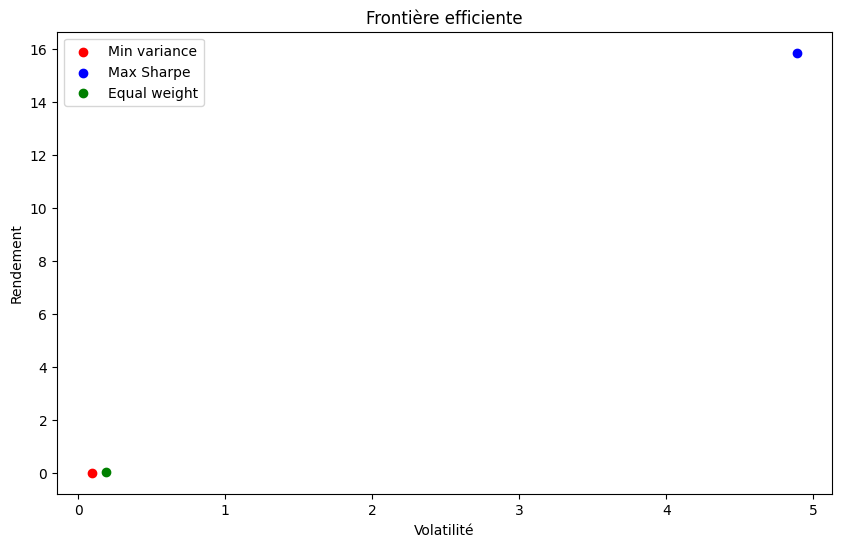

In [14]:
# Affichage des performances des portefeuilles
print("Performance des portefeuilles:")
print(f"Min variance: rendement = {ret_min_var:.2%}, volatilité = {vol_min_var:.2%}")
print(f"Max Sharpe: rendement = {ret_max_sharpe:.2%}, volatilité = {vol_max_sharpe:.2%}")
print(f"Equal weight: rendement = {ret_equal:.2%}, volatilité = {vol_equal:.2%}")
if ret_bl is not None:
    print(f"Black-Litterman: rendement = {ret_bl:.2%}, volatilité = {vol_bl:.2%}")
else:
    print("Black-Litterman: pas de solution")
    
# Affichage des portefeuilles optimaux
plt.figure(figsize=(10, 6))
plt.scatter(vol_min_var, ret_min_var, color='red', label='Min variance')
plt.scatter(vol_max_sharpe, ret_max_sharpe, color='blue', label='Max Sharpe')
plt.scatter(vol_equal, ret_equal, color='green', label='Equal weight')
if ret_bl is not None:
    plt.scatter(vol_bl, ret_bl, color='orange', label='Black-Litterman')
plt.xlabel('Volatilité')
plt.ylabel('Rendement')
plt.title('Frontière efficiente')
plt.legend()
plt.show()



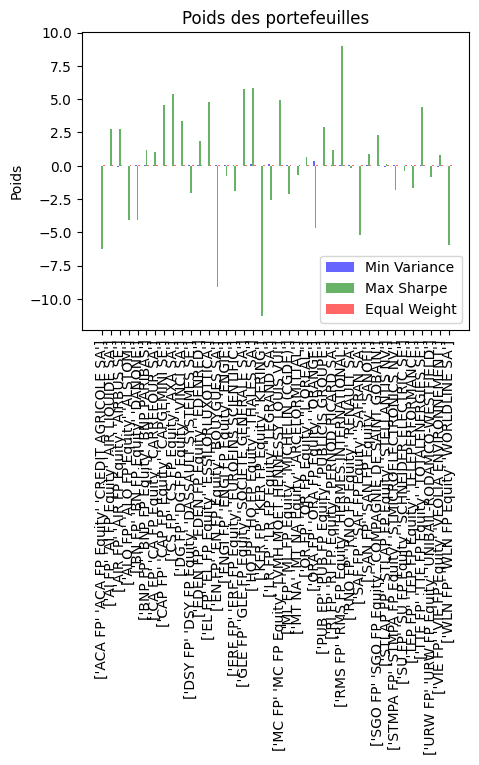

In [15]:
# Création de la fiche de présentation
plt.figure(figsize=(11, 8.5))  # Format A4

# Graphique des poids des portefeuilles

plt.subplot(2, 2, 1)
bar_width = 0.2
index = np.arange(len(names))
plt.bar(index, weights_min_var, width=bar_width, color='blue', alpha=0.6, label='Min Variance')
plt.bar(index + bar_width, weights_max_sharpe, width=bar_width, color='green', alpha=0.6, label='Max Sharpe')
plt.bar(index + 2*bar_width, weights_equal, width=bar_width, color='red', alpha=0.6, label='Equal Weight')
if weights_bl is not None:
    plt.bar(index + 3*bar_width, weights_bl, width=bar_width, color='orange', alpha=0.6, label='Black-Litterman')
plt.xticks(index + bar_width, names, rotation=90)
plt.ylabel('Poids')
plt.title('Poids des portefeuilles')    
plt.legend()



Text(0.5, 1.0, 'Performances des Portefeuilles')

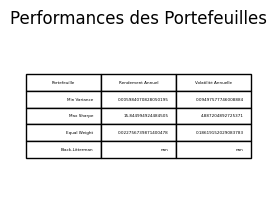

In [16]:
# Tableau des performances
plt.subplot(2, 2, 2)
performance_data = {
    'Portefeuille': ['Min Variance', 'Max Sharpe', 'Equal Weight', 'Black-Litterman'],
    'Rendement Annuel': [ret_min_var, ret_max_sharpe, ret_equal, ret_bl],
    'Volatilité Annuelle': [vol_min_var, vol_max_sharpe, vol_equal, vol_bl]
}
df_performance = pd.DataFrame(performance_data)
plt.table(cellText=df_performance.values, colLabels=df_performance.columns, loc='center')
plt.axis('off')
plt.title('Performances des Portefeuilles')



/var/folders/n1/xn0vyc1j3s73k04v3pxrskmm0000gp/T/ipykernel_6037/81496595.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


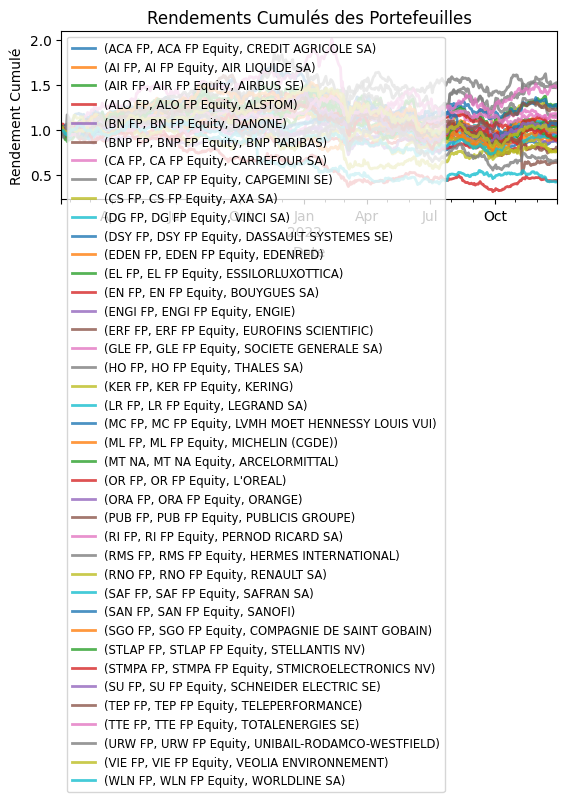

In [17]:
# Graphique des rendements cumulés
plt.subplot(2, 1, 2)  # Utilisez une disposition 2x1 pour plus d'espace

# Calcul des rendements cumulés
cumulative_returns = (1 + returns).cumprod()

# Tracé des rendements cumulés
cumulative_returns.plot(ax=plt.gca(), linewidth=2, alpha=0.8)

# Ajout de la légende
plt.legend(loc='upper left', fontsize='small')

# Ajout du titre et des étiquettes des axes
plt.title('Rendements Cumulés des Portefeuilles', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Rendement Cumulé', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

